In [1]:
"""
- 필요한 라이브러리들은 모두 여기서 한번에 import 
- font 또한 여기서 한번에 정리한다. 
"""
import numpy as np 
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import itertools
from itertools import combinations
from collections import Counter, namedtuple

from oauth2client.service_account import ServiceAccountCredentials
import gspread

## fontproperties 설정
BMDOHYEON = fm.FontProperties(fname='/Users/frhyme/Library/Fonts/BMDOHYEON_otf.otf')
BMJUA = fm.FontProperties(fname='/Users/frhyme/Library/Fonts/BMJUA_otf.otf')
BMHANNA = fm.FontProperties(fname='/Users/frhyme/Library/Fonts/BMHANNA_11yrs_otf.otf')
SDMiSaeng = fm.FontProperties(fname='/Users/frhyme/Library/Fonts/SDMiSaeng.ttf')
nanum = fm.FontProperties(fname='/Library/Fonts/NanumSquareOTFB.otf')
TimesNewRoman = fm.FontProperties(fname='/Library/Fonts/Times New Roman.ttf')

## 구글 시트로부터, 파일을 읽고 리리스트에 정리해줌
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('/Users/frhyme/Downloads/My Project-6f3701259a8e.json', scope)
## authorize
gc = gspread.authorize(credentials).open("!individual_meet_report")
## sheet file 이름을 넘겨주고 읽습니다. 
wks0 = gc.get_worksheet(0)
wks1 = gc.get_worksheet(1)
all_rows = wks0.get_all_values()[1:] + wks1.get_all_values()[1:]

In [2496]:
raw_df = []
for row in all_rows:
    date, category = row[0], row[3].strip() 
    people = filter(lambda x: True if x.strip()!="" else False, row[4:]) ## 비어있는 셀 삭제 
    people = map(lambda x: x.strip(), people) ## 공백제거
    people = sorted(list(set(people))) ## 사람 이름 순으로 정렬해야 양방향성 서로다른 edge가 생기지 않음
    people.remove('이승훈')## 내가 들어있는 데이터는 무의미함. 
    raw_df.append((date, category, people))## 이렇게 정리하여 raw_df에 넣고 

## 데이터 프레임으로 변경하고, 정렬, index 리셋등 
## (date, category, people_lst)로 정리된 dataframe
raw_df = pd.DataFrame(raw_df, columns=['date', 'category', 'people'])
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df = raw_df.sort_values('date').reset_index(drop=True)

In [2508]:
def 인맥별만남누적비율그래프_plot():
## (사람, 만남빈도) 에 따라서 만든 df
    p_count_df = pd.DataFrame(Counter(itertools.chain.from_iterable(raw_df.people)).most_common(), columns=['people', 'count'])
    p_count_df['cum_percent'] = p_count_df['count'].cumsum()/(p_count_df['count'].sum())*100

    plt.figure(figsize=(12, 6))
    ## zorder는 일종의 layer의 우선순위 라고 생각하면 됨. 무엇이 가장 아래에 있고, 위에 있을 것인가를 결정해주는 것 
    plt.plot(p_count_df['cum_percent'], '--', color='red', alpha=0.5, linewidth=3, zorder=-1)

    ## 10, 50, 100명의 인맥이 전체 만남의 어느 정도의 누적 비율을 차지하는지 정리 
    scatter_lst = np.array([(i-1, p_count_df['cum_percent'].iloc()[i-1]) for i in [10, 50, 100]])
    plt.scatter(scatter_lst[:, 0], scatter_lst[:, 1], marker='o', s=500, color='red')
    xytext_lst = [(250, 25), (300, 50), (350, 75)]
    for i, xy in enumerate(scatter_lst):
        x, y = xy
        plt.annotate('인맥 상위 {:d}명 => {:.1f}%'.format(int(x+1), y), 
                     xy=xy, xytext=xytext_lst[i], fontsize=20, fontproperties= BMJUA, 
                     arrowprops=dict(facecolor='black', shrink=0.05, width=3, headwidth=10, edgecolor='black')
                )
    plt.xlabel('인맥', fontproperties= BMJUA)
    plt.ylabel("인맥별 만남 누적 %", fontproperties= BMJUA)
    plt.xticks(np.arange(0, 650, 150), 
               ['P_{:0<2d}'.format(p) for p in np.arange(0, 650, 150)], fontproperties=BMJUA, fontsize=12, )
    plt.yticks(np.arange(0, 105, 25), 
               ['{}%'.format(x) for x in np.arange(0, 105, 25)], fontproperties=BMJUA, fontsize=12, )
    plt.title("인맥 별 만남 누적 비율", fontproperties=BMJUA)
    plt.savefig('../../assets/images/markdown_img/180801_people_cumu_sum.png', dpi=200)
    plt.show()
    

In [2514]:
## 단 1번만 만난 사람 수 
## 전체 643명 중에서 234명을 단 한번만 만났고, 이는 약 36%
def 만남횟수별인맥_bar():
    p_count_df = pd.DataFrame(Counter(itertools.chain.from_iterable(raw_df.people)).most_common(), columns=['people', 'count'])
    p_count_df['cum_percent'] = p_count_df['count'].cumsum()/(p_count_df['count'].sum())*100

    xy = [("{}".format(i), np.sum(p_count_df['count']<=i)/len(p_count_df)*100) for i in [1, 2, 5, 10, ]]
    plt.figure(figsize=(12, 6))
    plt.bar([x[0] for x in xy], [x[1] for x in xy], 
            width=0.7, color='purple', alpha=0.6
            #edgecolor='black', #linewidth=5, 
           )
    ## bar 별로 글자 넣어주기 
    for i, _xy in enumerate(xy):
        x, y = _xy
        plt.text(i-0.14, y+3, s='{:.1f}%'.format(y), 
                 fontproperties=BMJUA, fontsize=20, color='crimson'
                )
    ## yticks 설정
    plt.ylim(0, 100)
    loc, label = plt.yticks()
    plt.yticks(loc, ["{:2.0f}%".format(y) for y in np.linspace(0, 100, 6)], fontproperties=BMJUA, fontsize=12)
    ## xticks 설정 
    loc, label = plt.xticks()
    plt.xticks(loc, ['{}번 이하'.format(x[0]) for x in xy], fontproperties=BMJUA, fontsize=15)
    plt.xlabel("전체 인맥 중 x 번 이하 만난 인맥 비율", fontproperties=BMJUA)
    plt.savefig("../../assets/images/markdown_img/180802_n_above_people_bar_char.png", dpi=200)
    plt.show()

In [2518]:
## read context sheet
context_sheet = gc.get_worksheet(-1)
people_tuple = namedtuple("people", 'name others')
people_context_dt = {}## key: 이름, value: 속한집단('남', '연구실' 등)
## context를 읽어서 딕셔너리 리스트로 정리합니다. 
for p in context_sheet.get_all_values()[1:]:
    p = filter(lambda x: True if x!='' else False, p)
    p = list(map(lambda x: x.strip(), p))
    people_context_dt[p[0]] = p[1:]

In [2530]:
def 전체인맥중남녀비율_pie():
    ## 인맥 중 남녀 비율 
    plt.figure(figsize=(6, 6))
    temp = Counter(['남' if '남' in v else '여' for v in people_context_lst.values()]).most_common()
    labels, xs = [x[0] for x in temp], [x[1] for x in temp]
    patches, texts, autotexts = plt.pie(labels = labels, x=xs, autopct='%1.1f%%', startangle=0, counterclock=False,explode=(0, 0.1)
                                       )
    for t in texts:
        t.set_color("black"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(20)
    ## pie 위의 텍스트를 다른 색으로 변경해주기 
    for t in autotexts:
        t.set_color("white"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(20)
    ## 리턴받은 patche 중에서 남자인 부분은 연하게 하고 여자인 부분의 색은 강하게 하여 변화시킴 
    patches[0].set_alpha(0.5), 

    patches[1].set_color("red"), patches[1].set_edgecolor('black')
    patches[1].set_linestyle('--'), patches[1].set_linewidth(3)

    ######
    plt.title("인맥 중 남녀 비율", fontproperties=BMJUA, fontsize=20)
    plt.tight_layout()
    #plt.savefig("../../assets/images/markdown_img/180802_people_gender_ratio.png", dpi=200)
    plt.show()
    
def 인맥중학교사람비율_pi():
    plt.figure(figsize=(6, 6))
    temp = Counter(['yes' if '포스텍' in v else 'no' for v in people_context_lst.values()]).most_common()
    labels, xs = [x[0] for x in temp], [x[1] for x in temp]
    patches, texts, autotexts = plt.pie(labels = labels, 
                                        x=xs, autopct='%1.1f%%',
                                        startangle=0,counterclock=False,explode=(0, 0.1)
                                       )
    for t in texts:
        t.set_color("black"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(20)
    ## pie 위의 텍스트를 다른 색으로 변경해주기 
    for t in autotexts:
        t.set_color("white"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(20)
    ## 포스텍만 강조 
    patches[0].set_alpha(0.8), patches[1].set_alpha(0.2)
    patches[0].set_color("red"), patches[1].set_color("blue"), 
    patches[0].set_edgecolor('black'), patches[0].set_linestyle('--'), patches[0].set_linewidth(3)


    ######
    plt.title("인맥 중 학교사람 비율", fontproperties=BMJUA, fontsize=20)
    #plt.savefig("../../assets/images/markdown_img/180802_people_in_postech.png", dpi=200)
    plt.show()
    
def 전체만남중남녀비율_pie():
    ## 만남 중 남녀 비율 
    ## 일단 raw_df에서 people_context에 있는 놈들만 걸러내고
    temp_df = raw_df['people'].apply(lambda lst: list(filter(lambda x: True if x in people_context_lst.keys() else False, lst)))
    ## 다시 df를 만든 다음 
    temp_df = list(itertools.chain.from_iterable(temp_df))

    ## 전체 만남 중 여자 비율 
    result = Counter(map(lambda x: '여' if '여' in people_context_lst[x] else '남', temp_df))

    labels, xs = result.keys(), result.values()
    plt.figure(figsize=(6, 6))
    patches, texts, autotexts = plt.pie(labels = labels, x=xs, autopct='%1.1f%%',startangle=0,
                                        counterclock=False,explode=(0, 0.1) )
    for t in texts:
        t.set_color("black"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(20)
    ## pie 위의 텍스트를 다른 색으로 변경해주기 
    for t in autotexts:
        t.set_color("white"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(20)
    ## 여자 부분만 강조 
    patches[0].set_alpha(0.5)
    patches[1].set_color("red"), patches[1].set_edgecolor('black')
    patches[1].set_linestyle('--'), patches[1].set_linewidth(3)

    ######
    plt.title("만남 중 남녀 비율", fontproperties=BMJUA, fontsize=20)
    plt.tight_layout()
    #plt.savefig("../../assets/images/markdown_img/180802_meet_gender_ratio.png", dpi=200)
    plt.show()

def 전체만남중_여자친구_어머니_제외시_남녀비율_pie():
    temp_df = raw_df['people'].apply(lambda lst: list(filter(lambda x: True if x in people_context_lst.keys() else False, lst)))
    temp_df = list(itertools.chain.from_iterable(temp_df))

    ## 전체 만남 중 여자 비율 여자친구/어머니 제외 
    result = Counter(map(lambda x: '여' if '여' in people_context_lst[x] and '어머니' not in people_context_lst[x] and '여자친구' not in people_context_lst[x]
                         else '남', temp_df))

    labels, xs = result.keys(), result.values()
    plt.figure(figsize=(6, 6))
    patches, texts, autotexts = plt.pie(labels = labels, x=xs, autopct='%1.1f%%',
                                        startangle=0, pctdistance=0.75, labeldistance=1.02, 
                                        counterclock=False,explode=(0, 0.2))
    for t in texts:
        t.set_color("black"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(20)
    ## pie 위의 텍스트를 다른 색으로 변경해주기 
    for t in autotexts:
        t.set_color("white"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(18)
    ## 여자 부분만 강조 
    patches[0].set_alpha(0.5)
    patches[1].set_color("red"), patches[1].set_edgecolor('black')
    patches[1].set_linestyle('--'), patches[1].set_linewidth(3)

    ######
    plt.title("만남 중 남녀 비율(여자친구/어머니 제외)", fontproperties=BMJUA, fontsize=20)
    plt.tight_layout()
    #plt.savefig("../../assets/images/markdown_img/180802_meet_gender_ratio_without.png", dpi=200)
    plt.show()

def 만남중_가족여자친구비율비교_pi():
    temp_df = raw_df['people'].iloc()[:4812].apply(lambda lst: list(filter(lambda x: True if x in ['어머니', '이정호', '임소희'] else False, lst)))
    temp_df = list(itertools.chain.from_iterable(temp_df))
    temp_df = map(lambda x: '가족' if x in ['이정호', '어머니'] else '여자친구', temp_df)
    temp = Counter(temp_df).most_common()

    labels, xs = [x[0] for x in temp], [x[1] for x in temp]

    plt.figure(figsize=(6, 6))
    patches, texts, autotexts = plt.pie(labels = labels, 
                                        x=xs, autopct='%1.1f%%', startangle=270,
                                        counterclock=False,explode=(0, 0.1)
                                       )
    for t in texts:
        t.set_color("black"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(20)
    ## pie 위의 텍스트를 다른 색으로 변경해주기 
    for t in autotexts:
        t.set_color("white"), t.set_fontproperties(BMDOHYEON), t.set_fontsize(20)
    ## 포스텍만 강조 
    patches[0].set_alpha(0.8), patches[1].set_alpha(0.2)
    patches[0].set_color("red"), patches[1].set_color("blue"), 
    patches[0].set_edgecolor('black'), patches[0].set_linestyle('--'), patches[0].set_linewidth(3)

    ######
    plt.title("만남 중 가족/여자친구 비율 비교", fontproperties=BMJUA, fontsize=20)
    #plt.savefig("../../assets/images/markdown_img/180802_family_girlfriend_comp.png", dpi=200)
    plt.show()

In [2521]:
###################################

[595, 9, 4, 9, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1]


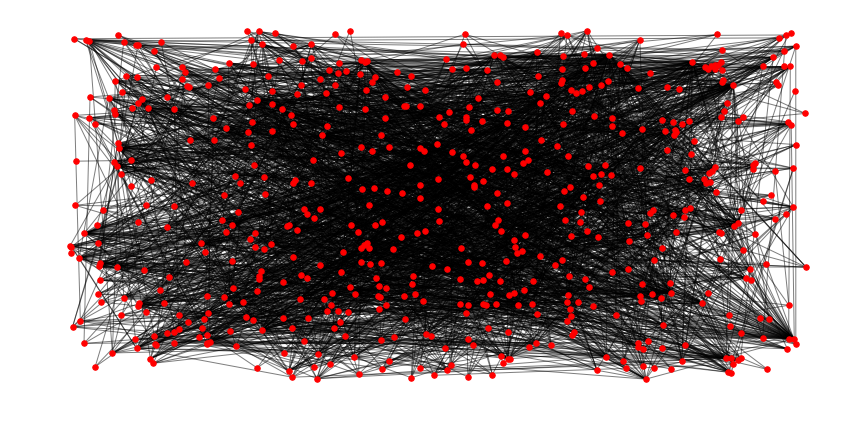

In [2561]:
## 그래프 생성 
G = nx.Graph()
## add node 
G.add_nodes_from([(name, {'weight':count}) 
                  for name, count in Counter(itertools.chain.from_iterable(raw_df.people)).most_common()])
## add edge 
edges = []
for row in raw_df.people:
    ## 이미 위에서 정렬을 했지만, 그냥 한 번 더 해줌 깔깔 
    edges += [tuple(sorted([row[i], row[j]])) for i in range(0, len(row)-1) for j in range(i+1, len(row))]
G.add_edges_from([(edge[0], edge[1],{'weight':count}) for edge, count in Counter(edges).most_common()])
#G.add_weighted_edges_from(Counter(edges).most_common())

## 딱 한 번 만난 인맥은 지우자 
def remove_below_n_nodes(inputG, below_n):
    remove_nodes = filter(lambda n: True if n[1]['weight']<below_n else False, inputG.nodes(data=True))
    remove_nodes = map(lambda x: x[0], remove_nodes)
    inputG.remove_nodes_from(list(remove_nodes))

## 이상한 몇 가지 node를 지우자 
## 누군지 기억이 잘 나지 않는 node는 지워야 합니다. 
# G.remove_nodes_from(remove_node)

## connected component에서 가장 큰 놈만 을 max_size_subG에 저장해둡니다. 
## 나머지는 노드 수가 너무 작아서 큰 의미가 없을 것 같아요 
subG_lst = [subG for subG in nx.connected_component_subgraphs(G)]
print([len(subG) for subG in subG_lst])
## 이제 그렇다면, 가장 큰 사이즈의 subG 
max_size_subG = max(subG_lst, key=lambda x: len(x.nodes()))

##
plt.figure(figsize=(12, 6))
pos = nx.random_layout(max_size_subG)
nx.draw_networkx_edges(max_size_subG, pos, alpha=0.5)
nx.draw_networkx_nodes(max_size_subG, pos, node_size=30)
plt.axis('off')
plt.tight_layout()
#plt.savefig('../../assets/images/markdown_img/180802_network_graph.png', dpi=200)
plt.show()

In [2567]:
def longest_shortest_path():
    all_possible_paths = []
    diameter = nx.diameter(max_size_subG)
    for n1, n2 in combinations(max_size_subG.nodes(), 2):
        new_path = nx.shortest_path(max_size_subG, n1, n2)
        if len(new_path)==diameter:
            all_possible_paths.append(new_path)
    ## all_possible_paths
    ## 이 path로 케빈베이컨이 된다 는 것을 보여주면 되겠네. 
    return all_possible_paths

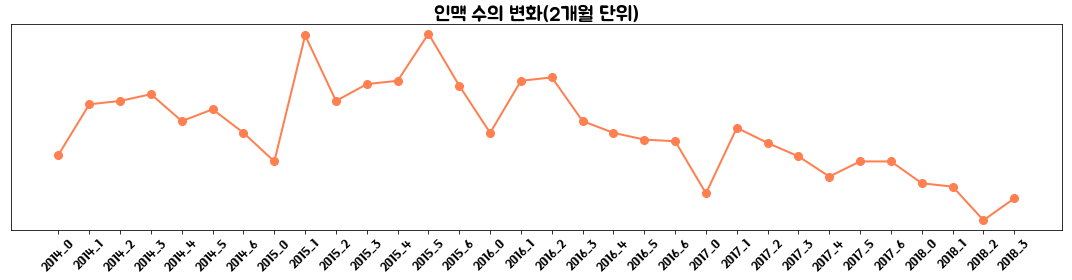

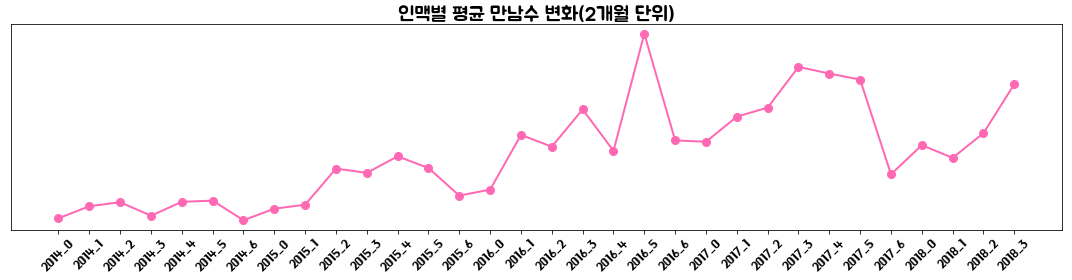

In [2542]:
## 월별 만나는 인맥 수, 사람 수의 변화 
def 월별만나는인맥수변화():
    ym_lst = []
    meet_lst = []
    people_lst = []
    for g_name, group in raw_df.groupby(lambda idx: "{}_{:1d}".format(raw_df['date'].loc()[idx].year, raw_df['date'].loc()[idx].month//2)):
        all_meet = itertools.chain.from_iterable(group['people'])
        all_meet = list(all_meet)
        all_people = list(set(all_meet))
        ym_lst.append(g_name)
        meet_lst.append(len(all_meet))
        people_lst.append(len(all_people))
    ym_df = pd.DataFrame({'meet':meet_lst[1:], 'people':people_lst[1:]}, index=ym_lst[1:])
    ym_df['m_div_p'] = ym_df['meet']/ym_df['people']

    ## 월별 인맥의 수는 점차 감소하고 있음. 
    plt.figure(figsize=(15, 4))
    plt.plot(ym_df['people'], marker='o', markersize=8, 
             linestyle='-', linewidth=2, color='coral')

    plt.title("인맥 수의 변화(2개월 단위)", fontproperties=BMJUA, fontsize=20)
    plt.xticks(fontproperties=BMHANNA, rotation=45, fontsize=12), plt.yticks([])
    plt.tight_layout()
    #plt.savefig('../../assets/images/markdown_img/180802_month_2_people_change.png', dpi=200)
    plt.show()
    
def 월별만나는사람수변화():
    ym_lst = []
    meet_lst = []
    people_lst = []
    for g_name, group in raw_df.groupby(lambda idx: "{}_{:1d}".format(raw_df['date'].loc()[idx].year, raw_df['date'].loc()[idx].month//2)):
        all_meet = itertools.chain.from_iterable(group['people'])
        all_meet = list(all_meet)
        all_people = list(set(all_meet))
        ym_lst.append(g_name)
        meet_lst.append(len(all_meet))
        people_lst.append(len(all_people))
    ym_df = pd.DataFrame({'meet':meet_lst[1:], 'people':people_lst[1:]}, index=ym_lst[1:])
    ym_df['m_div_p'] = ym_df['meet']/ym_df['people']

    meet_div_people = np.array(meet_lst) / np.array(people_lst)
    plt.figure(figsize=(15, 4))
    plt.plot(ym_df['m_div_p'], marker='o', markersize=8, 
             linestyle='-', linewidth=2, color='hotpink')
    plt.xticks(fontproperties=BMHANNA, rotation=45, fontsize=12), plt.yticks([])
    plt.title("인맥별 평균 만남수 변화(2개월 단위)", fontproperties=BMJUA, fontsize=20)
    plt.tight_layout()
    #plt.savefig('../../assets/images/markdown_img/180802_month_2_avg_meet_people_change.png', dpi=200)
    plt.show()
월별만나는인맥수변화()
월별만나는사람수변화()

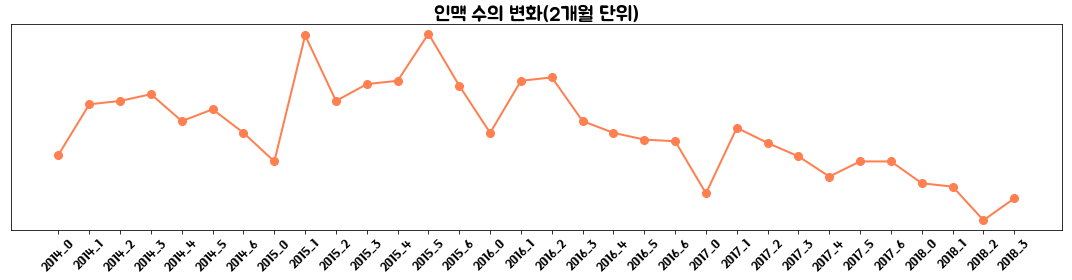

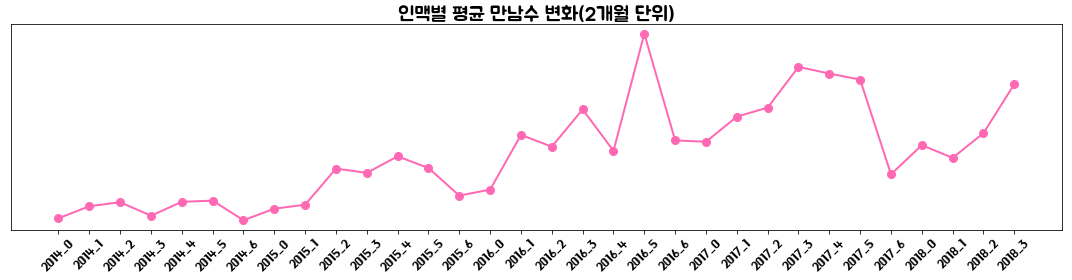

In [2539]:
## 월별 만나는 인맥 수, 사람 수의 변화 
def 월별만나는사람수변화():
    ym_lst = []
    meet_lst = []
    people_lst = []
    for g_name, group in raw_df.groupby(lambda idx: "{}_{:1d}".format(raw_df['date'].loc()[idx].year, raw_df['date'].loc()[idx].month//2)):
        all_meet = itertools.chain.from_iterable(group['people'])
        all_meet = list(all_meet)
        all_people = list(set(all_meet))
        ym_lst.append(g_name)
        meet_lst.append(len(all_meet))
        people_lst.append(len(all_people))
    ym_df = pd.DataFrame({'meet':meet_lst[1:], 'people':people_lst[1:]}, index=ym_lst[1:])
    ym_df['m_div_p'] = ym_df['meet']/ym_df['people']

    meet_div_people = np.array(meet_lst) / np.array(people_lst)
    plt.figure(figsize=(15, 4))
    plt.plot(ym_df['m_div_p'], marker='o', markersize=8, 
             linestyle='-', linewidth=2, color='hotpink')
    plt.xticks(fontproperties=BMHANNA, rotation=45, fontsize=12), plt.yticks([])
    plt.title("인맥별 평균 만남수 변화(2개월 단위)", fontproperties=BMJUA, fontsize=20)
    plt.tight_layout()
    #plt.savefig('../../assets/images/markdown_img/180802_month_2_avg_meet_people_change.png', dpi=200)
    plt.show()

In [779]:
## 월별 인맥 과 만남 수의 변화 
G_lst = []
G_name_lst = []
for g_name, group in raw_df.groupby(lambda idx: "{}_{:0>2d}".format(raw_df['date'].loc()[idx].year, raw_df['date'].loc()[idx].month)):
    g = nx.Graph()
    ## add node
    g.add_nodes_from([(name, {'weight':count}) 
                      for name, count in Counter(itertools.chain.from_iterable(group.people)).most_common()])
    ## add edge 
    edges = []
    for row in group.people:
        edges += [tuple(sorted([row[i], row[j]])) for i in range(0, len(row)-1) for j in range(i+1, len(row))]
    g.add_edges_from([(edge[0], edge[1],{'weight':count}) for edge, count in Counter(edges).most_common()])
    G_name_lst.append(g_name)
    G_lst.append(g)

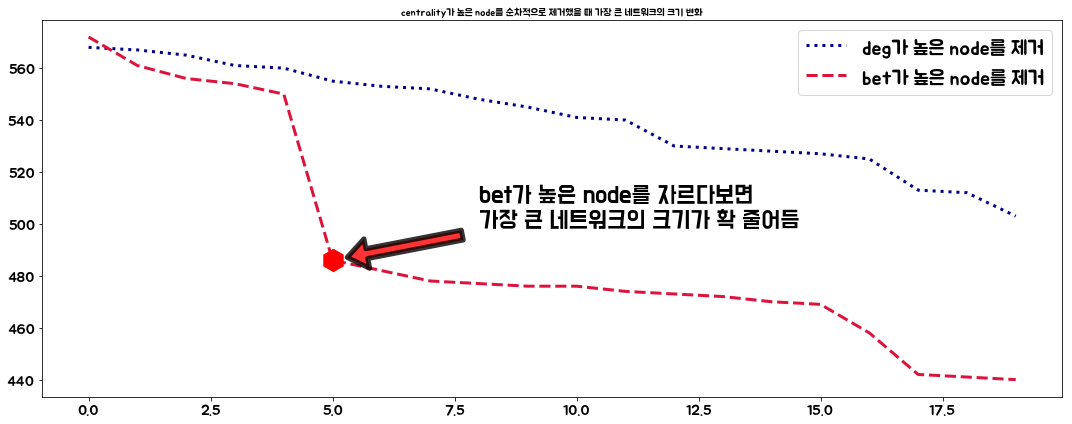

In [2557]:
def deg_bet가높은node를지우면서네트워크크기변화():
    deg_rank = sorted(list(nx.degree_centrality(max_size_subG).items()), key=lambda x: x[1], reverse=True)
    bet_rank = sorted(list(nx.betweenness_centrality(max_size_subG).items()), key=lambda x: x[1], reverse=True)
    tempG = max_size_subG.copy()
    max_g_size_change_lst_deg = []
    for i in range(0, 20):
        tempG.remove_node(deg_rank[i][0])
        all_comp = list(nx.connected_component_subgraphs(tempG))
        subgroup_count = len(all_comp)
        max_g_size_change_lst_deg.append(len(max(all_comp, key=lambda x: len(x.nodes())).nodes()))
        #print(subgroup_count, max_subgroup_count)
    ##### bet
    tempG = max_size_subG.copy()
    max_g_size_change_lst_bet = []
    for i in range(0, 20):
        tempG.remove_node(bet_rank[i][0])
        all_comp = list(nx.connected_component_subgraphs(tempG))
        subgroup_count = len(all_comp)
        max_g_size_change_lst_bet.append(len(max(all_comp, key=lambda x: len(x.nodes())).nodes()))
        #print(subgroup_count, max_subgroup_count)
    plt.figure(figsize=(15, 6))
    plt.plot(max_g_size_change_lst_deg, color='darkblue', linewidth=3, linestyle=':',
             label='deg가 높은 node를 제거')
    plt.plot(max_g_size_change_lst_bet, color='crimson', linewidth=3, linestyle='--',
             label='bet가 높은 node를 제거')
    plt.scatter(5, max_g_size_change_lst_bet[5], marker='h', color='red', s=500, zorder=5, )
    plt.annotate('bet가 높은 node를 자르다보면 \n가장 큰 네트워크의 크기가 확 줄어듬', ## 텍스트
                 xy=(5, max_g_size_change_lst_bet[5]), xytext=(8, 500),
                 fontsize=20, fontproperties=BMDOHYEON, 
                 arrowprops=dict(facecolor='red', edgecolor='black', shrink=0.1, 
                                 headwidth=30,headlength=20, width=10, linewidth=5, alpha=0.8, )
                )
    ## 
    plt.legend(prop={'family':BMJUA.get_name(), 'size':20})
    plt.xticks(fontproperties=BMJUA, fontsize=15), plt.yticks(fontproperties=BMJUA, fontsize=15)
    plt.title('centrality가 높은 node를 순차적으로 제거했을 때 가장 큰 네트워크의 크기 변화', fontproperties=BMJUA)
    plt.tight_layout()
    ## plt.savefig('../../assets/images/markdown_img/180807_remove_bet_node_change.png', dpi=200)
    plt.show()
deg_bet가높은node를지우면서네트워크크기변화()